[![ Click here to deploy.](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/launchable/deploy/now?launchableID=env-2rgiXa7D63Aq0bmKElJq2HpAY2x)

NOTE: it takes about 10 minutes to deploy this notebook as a Launchable. As of this writing, we are working on a free tier so a credit card may be required. You can reach out to your NVIDIA rep for credits."

# Building Generative Models for Continuous Data via Continuous Interpolants

In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.datasets import make_moons

# Task Setup

To demonstrate how Conditional Flow Matching works we use sklearn to sample from and create custom 2D distriubtions.

To start we define our "dataloader" so to speak. This is the '''sample_moons''' function.

Next we define a custom PriorDistribution to enable the conversion of 8 equidistance gaussians to the moon distribution above.



In [2]:
def sample_moons(n, normalize = False):
    x1, _ = make_moons(n_samples=n, noise=0.08)
    x1 = torch.Tensor(x1)
    x1 =  x1 * 3 - 1
    if normalize:
        x1 = (x1 - x1.mean(0))/x1.std(0) * 2
    return x1

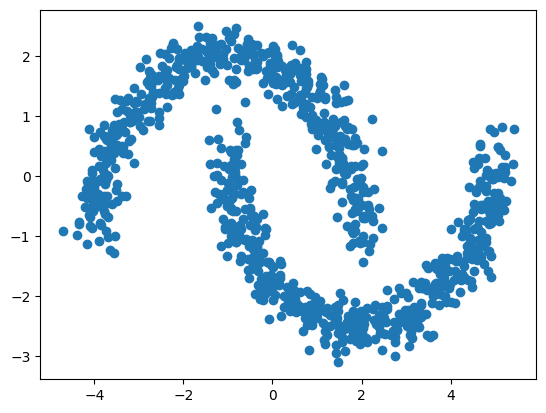

In [3]:
x1 = sample_moons(1000)
plt.scatter(x1[:, 0], x1[:, 1])

# Model Creation
Here we define a simple 4 layer MLP and define our optimizer

In [4]:
import math
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(
        self, dim_in: int, dim_out: int, dim_hids: List[int],
    ):
        super().__init__()
        self.layers = nn.ModuleList([
            TimeLinear(dim_in, dim_hids[0]),
            *[TimeLinear(dim_hids[i-1], dim_hids[i]) for i in range(1, len(dim_hids))],
            TimeLinear(dim_hids[-1], dim_out)
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        for i, layer in enumerate(self.layers):
            x = layer(x, t)
            if i < len(self.layers) - 1:
                x = F.relu(x)
        return x
        
class TimeLinear(nn.Module):
    def __init__(self, dim_in: int, dim_out: int):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out

        self.time_embedding = TimeEmbedding(dim_out)
        self.fc = nn.Linear(dim_in, dim_out)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.fc(x)
        alpha = self.time_embedding(t).view(-1, self.dim_out)
        return alpha * x
        
class TimeEmbedding(nn.Module):
    # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
        return embedding

    def forward(self, t: torch.Tensor):
        if t.ndim == 0:
            t = t.unsqueeze(-1)
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb

# Now let's try a continuous time analog interpolant to DDPM called VDM

### This interpolant was used in Chroma and is described in great detail here https://www.biorxiv.org/content/10.1101/2022.12.01.518682v1.full.pdf

In [5]:
from bionemo.moco.distributions.time import UniformTimeDistribution
from bionemo.moco.interpolants import VDM
from bionemo.moco.schedules.noise.continuous_snr_transforms import CosineSNRTransform, LinearSNRTransform, LinearLogInterpolatedSNRTransform
from bionemo.moco.schedules.inference_time_schedules import LinearInferenceSchedule
from bionemo.moco.distributions.prior.continuous.gaussian import GaussianPrior
DEVICE = "cuda:0"
uniform_time = UniformTimeDistribution(discrete_time=False)
simple_prior = GaussianPrior()
vdm = VDM(time_distribution=uniform_time, 
            prior_distribution=simple_prior,
            prediction_type = "data",
            noise_schedule = LinearLogInterpolatedSNRTransform(),
            device=DEVICE)
schedule = LinearInferenceSchedule(nsteps = 1000, direction="diffusion")

In [6]:
# Place both the model and the interpolant on the same device
dim = 2
hidden_size = 128
num_hiddens = 3
batch_size = 256
model = Network(dim_in=dim, 
                dim_out=dim, 
                dim_hids=[hidden_size]*num_hiddens)
DEVICE = "cuda"
model = model.to(DEVICE)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1.e-3)
for k in range(20000):
    optimizer.zero_grad()
    shape = (batch_size, dim)
    x0 = vdm.sample_prior(shape).to(DEVICE)
    x1 = sample_moons(batch_size).to(DEVICE)

    t = vdm.sample_time(batch_size)
    xt = vdm.interpolate(x1, t, x0)

    x_hat = model(xt, t)
    loss = vdm.loss(x_hat, x1, t, weight_type="ones").mean()

    loss.backward()
    optimizer.step()

    if (k + 1) % 1000 == 0:
        print(f"{k+1}: loss {loss.item():0.3f}") 

1000: loss 1.060
2000: loss 1.136
3000: loss 1.254
4000: loss 1.176
5000: loss 1.070
6000: loss 1.447
7000: loss 1.042
8000: loss 1.187
9000: loss 1.063
10000: loss 1.275
11000: loss 1.481
12000: loss 0.951
13000: loss 1.014
14000: loss 0.973
15000: loss 1.053
16000: loss 1.114
17000: loss 1.056
18000: loss 1.249
19000: loss 1.020
20000: loss 1.332


In [8]:
with torch.no_grad():
    inf_size = 1024
    sample = vdm.sample_prior((inf_size, 2)).to(DEVICE) # Start with noise
    trajectory = [sample.cpu()]
    ts = schedule.generate_schedule()
    dts = schedule.discretize()
    for dt, t in zip(dts, ts):
        full_t  = torch.full((inf_size,), t).to(DEVICE)
        x_hat = model(sample, full_t) # calculate the vector field based on the definition of the model
        sample = vdm.step(x_hat, full_t, sample, dt)
        trajectory.append(sample.cpu()) # save the trajectory for plotting purposes


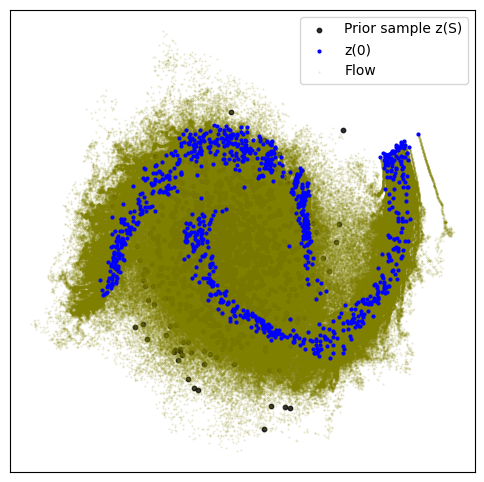

In [9]:
import matplotlib.pyplot as plt
traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(S)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(0)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
with torch.no_grad():
    inf_size = 1024
    sample = vdm.sample_prior((inf_size, 2)).to(DEVICE) # Start with noise
    trajectory = [sample.cpu()]
    ts = schedule.generate_schedule()
    dts = schedule.discretize()
    for dt, t in zip(dts, ts):
        full_t  = torch.full((inf_size,), t).to(DEVICE)
        x_hat = model(sample, full_t) # calculate the vector field based on the definition of the model
        sample = vdm.step_ddim(x_hat, full_t, sample, dt)
        trajectory.append(sample.cpu()) # save the trajectory for plotting purposes


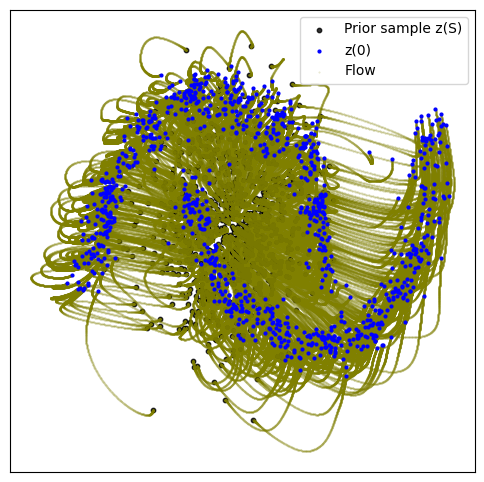

In [11]:
import matplotlib.pyplot as plt
traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(S)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(0)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

## What is interesting here is that the deterministic sampling of DDIM best recovers the Flow Matching ODE samples

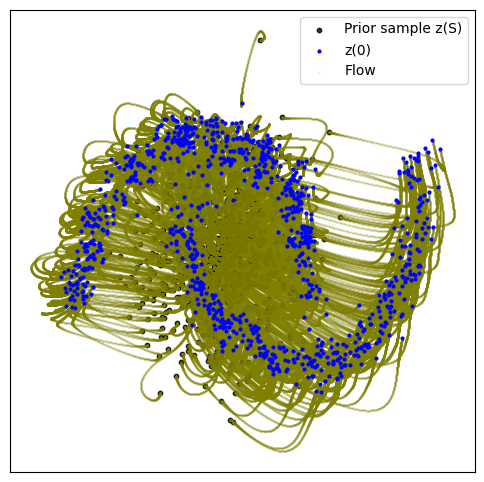

In [13]:
with torch.no_grad():
    inf_size = 1024
    sample = vdm.sample_prior((inf_size, 2)).to(DEVICE) # Start with noise
    trajectory = [sample.cpu()]
    ts = schedule.generate_schedule()
    dts = schedule.discretize()
    for dt, t in zip(dts, ts):
        full_t  = torch.full((inf_size,), t).to(DEVICE)
        x_hat = model(sample, full_t) # calculate the vector field based on the definition of the model
        # sample = vdm.step_hybrid_sde(x_hat, full_t, sample, dt)
        sample = vdm.step_ode(x_hat, full_t, sample, dt)
        trajectory.append(sample.cpu()) # save the trajectory for plotting purposes
    
traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(S)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(0)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

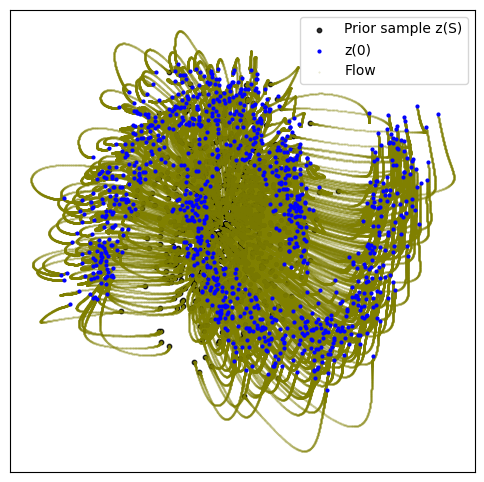

In [14]:
with torch.no_grad():
    inf_size = 1024
    sample = vdm.sample_prior((inf_size, 2)).to(DEVICE) # Start with noise
    trajectory = [sample.cpu()]
    ts = schedule.generate_schedule()
    dts = schedule.discretize()
    for dt, t in zip(dts, ts):
        full_t  = torch.full((inf_size,), t).to(DEVICE)
        x_hat = model(sample, full_t) # calculate the vector field based on the definition of the model
        # sample = vdm.step_hybrid_sde(x_hat, full_t, sample, dt)
        sample = vdm.step_ode(x_hat, full_t, sample, dt, temperature = 1.5)
        trajectory.append(sample.cpu()) # save the trajectory for plotting purposes
    
traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

# Assuming traj is your tensor and traj.shape = (N, 2000, 2)
# where N is the number of time points, 2000 is the number of samples at each time point, and 2 is for the x and y coordinates.

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(S)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(0)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

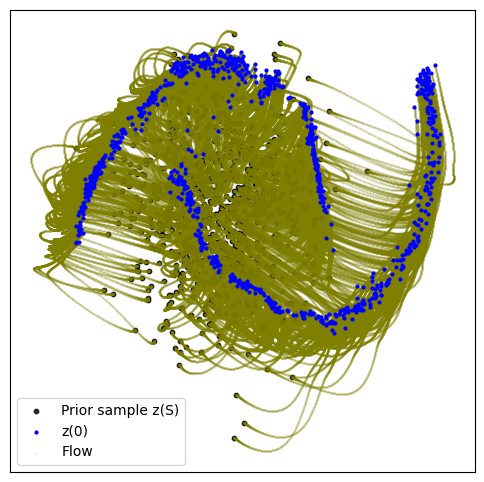

In [15]:
with torch.no_grad():
    inf_size = 1024
    sample = vdm.sample_prior((inf_size, 2)).to(DEVICE) # Start with noise
    trajectory = [sample.cpu()]
    ts = schedule.generate_schedule()
    dts = schedule.discretize()
    for dt, t in zip(dts, ts):
        full_t  = torch.full((inf_size,), t).to(DEVICE)
        x_hat = model(sample, full_t) # calculate the vector field based on the definition of the model
        # sample = vdm.step_hybrid_sde(x_hat, full_t, sample, dt)
        sample = vdm.step_ode(x_hat, full_t, sample, dt, temperature = 0.5)
        trajectory.append(sample.cpu()) # save the trajectory for plotting purposes
        
traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(S)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(0)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

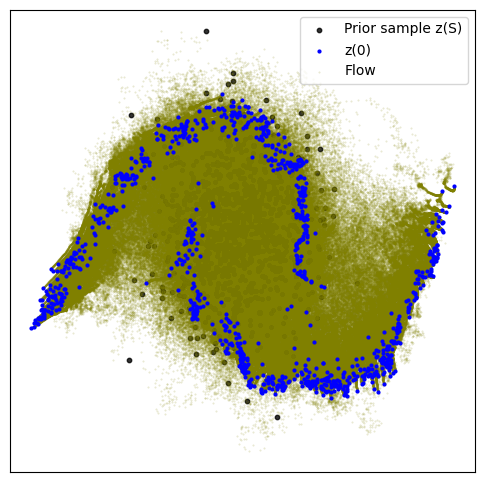

In [42]:
inf_size = 1024
sample = vdm.sample_prior((inf_size, 2)).to(DEVICE) # Start with noise
trajectory = [sample]
ts = schedule.generate_schedule()
dts = schedule.discretize()
for dt, t in zip(dts, ts):
    full_t  = torch.full((inf_size,), t).to(DEVICE)
    x_hat = model(sample, full_t) # calculate the vector field based on the definition of the model
    sample = vdm.step_hybrid_sde(x_hat, full_t, sample, dt)
    # sample = vdm.step_ode(x_hat, full_t, sample, dt)
    trajectory.append(sample) # save the trajectory for plotting purposes
    
traj = torch.stack(trajectory).cpu().detach().numpy()
plot_limit = 1024

plt.figure(figsize=(6, 6))

# Plot the first time point in black
plt.scatter(traj[0, :plot_limit, 0], traj[0, :plot_limit, 1], s=10, alpha=0.8, c="black", label='Prior sample z(S)')

# Plot all the rest of the time points except the first and last in olive
for i in range(1, traj.shape[0]-1):
    plt.scatter(traj[i, :plot_limit, 0], traj[i, :plot_limit, 1], s=0.2, alpha=0.2, c="olive")

# Plot the last time point in blue
plt.scatter(traj[-1, :plot_limit, 0], traj[-1, :plot_limit, 1], s=4, alpha=1, c="blue", label='z(0)')

# Add a second legend for "Flow" since we can't label in the loop directly
plt.scatter([], [], s=0.2, alpha=0.2, c="olive", label='Flow')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()